In [1]:
# LETS IMPORT THE LIBRARIES 
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os


In [2]:
# dataset used 
link = "https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset/data"

dataframe is 
    Emotion  Count
0  surprise   5920
1      fear   5920
2     angry   5920
3   neutral   8166
4       sad   6535
5   disgust   5920
6     happy  11398
Total number of images are 49779


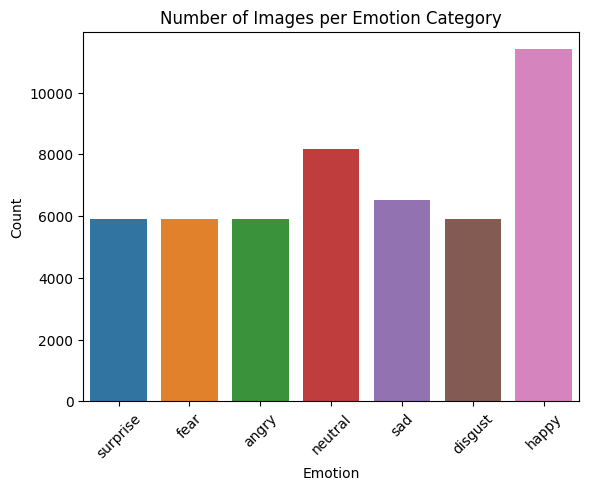

In [3]:
# lets import the dataset 
datapath = "/kaggle/input/facial-emotion-recognition-dataset/processed_data"


# List all emotion folders inside the base path
emotion_folders = os.listdir(datapath)

# Count images in each folder
image_counts = {}
for emotion in emotion_folders:
    emotion_path = os.path.join(datapath, emotion)
    if os.path.isdir(emotion_path):
        image_counts[emotion] = len(os.listdir(emotion_path))

# Convert to DataFrame for easy plotting
df = pd.DataFrame(list(image_counts.items()), columns=['Emotion', 'Count'])
print(f"dataframe is \n{df}")
print(f"Total number of images are {df['Count'].sum()}")

# Plot count plot
sns.barplot(data=df, x='Emotion', y='Count')
plt.title('Number of Images per Emotion Category')
plt.xticks(rotation=45)
plt.show()


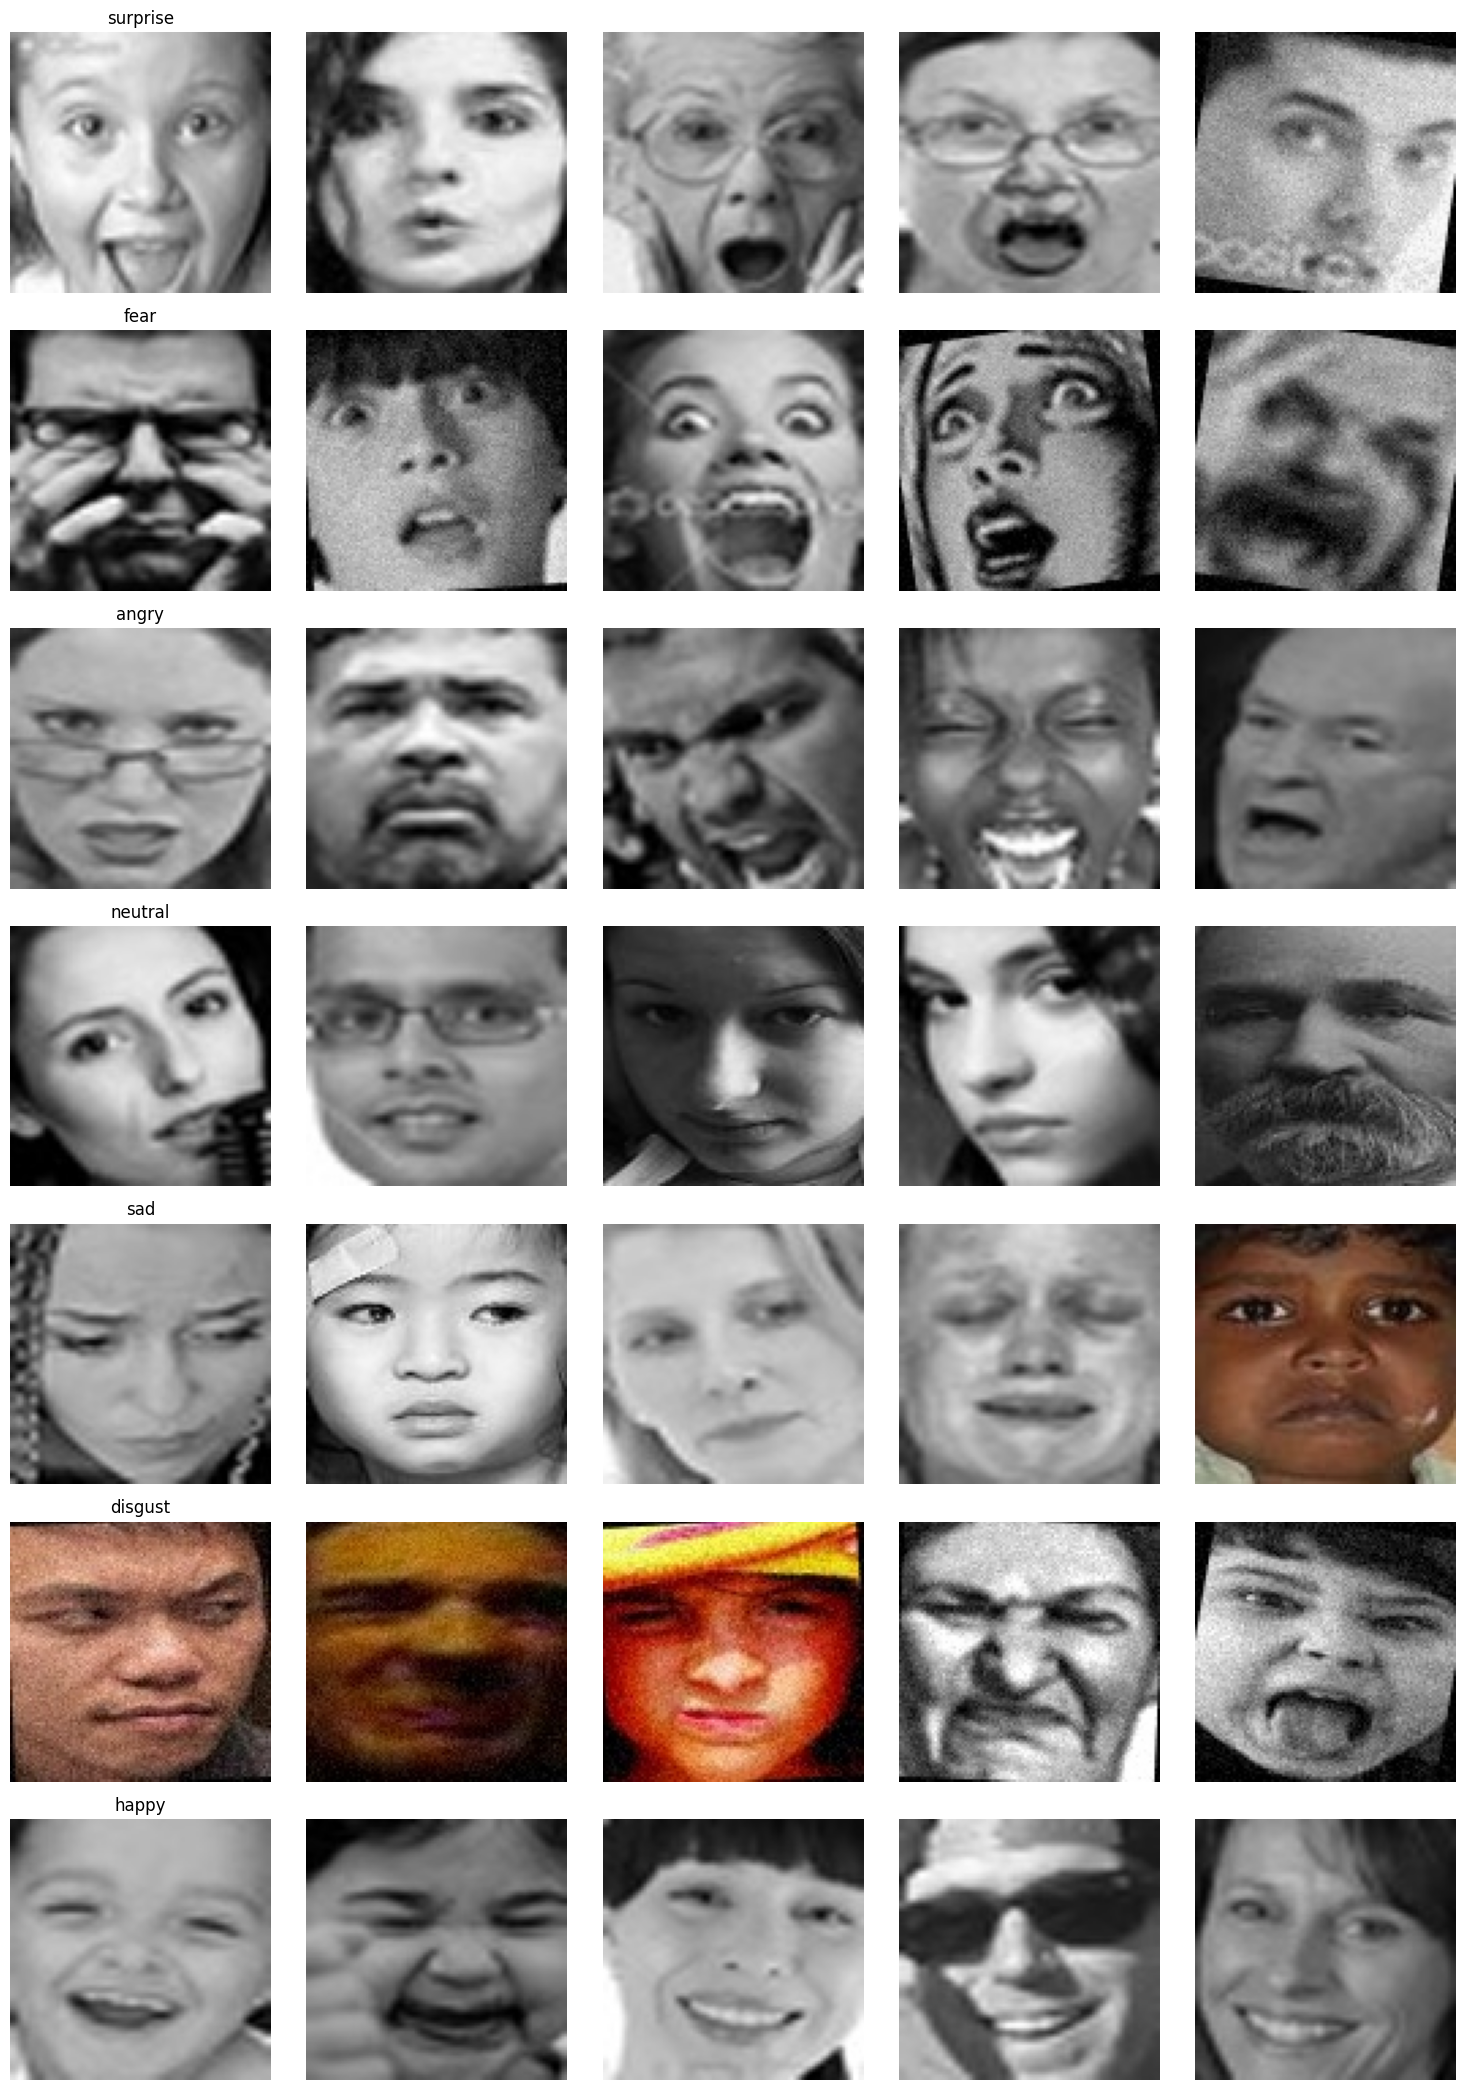

In [4]:
# LETS PLOT SOME IMAGES 
import os
import cv2
import matplotlib.pyplot as plt

# Base path to your dataset
base_path = datapath

# List emotion class folders
class_folders = os.listdir(base_path)

# Number of samples to show per class
num_samples = 5

plt.figure(figsize=(15, len(class_folders)*3))

for i, emotion in enumerate(class_folders):
    emotion_path = os.path.join(base_path, emotion)
    images = os.listdir(emotion_path)[:num_samples]  # Take first 5 images

    for j, img_name in enumerate(images):
        img_path = os.path.join(emotion_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plt.imshow()

        # Plot position: rows = classes, cols = samples per class
        plt.subplot(len(class_folders), num_samples, i*num_samples + j + 1)
        plt.imshow(img)
        plt.axis('off')

        if j == 0:
            plt.title(emotion)

plt.tight_layout()
plt.show()


In [5]:
# AS WE OBSERVE THERE IS CLASS IMBALANCE IN THE DATASET
# SO WE ARE USING DATA AUGEMENTATION TO BALANCE THE DATASET


In [6]:
import cv2

# Read the image from file
img = cv2.imread('/kaggle/input/facial-emotion-recognition-dataset/processed_data/angry/angry_00000.jpg')

# Get image dimensions
height = img.shape[0]
width = img.shape[1]

# For color images, number of channels is shape[2]
channels = img.shape[2] 

print(f"Image size: {width}x{height} pixels")
print(f"Number of channels: {channels}")


Image size: 96x96 pixels
Number of channels: 3


In [7]:
# images are of small sizes (96,96)

In [8]:
# LETS IMPORT LIBRARY FOR DATA LOADING
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data for validation
)

# Training data generator
traindata = train_datagen.flow_from_directory(
    base_path,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    subset='training',       # Specify training set
    shuffle=True,
    seed=42
)

# Validation data generator (note: no heavy augmentation)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

validationdata = valid_datagen.flow_from_directory(
    base_path,
    target_size=(96,96),
    batch_size=32,
    class_mode='categorical',
    subset='validation',     # Specify validation set
    shuffle=False,
    seed=42
)


2025-10-08 09:11:14.917174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759914675.173779      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759914675.240746      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 39824 images belonging to 7 classes.
Found 9955 images belonging to 7 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pretrained MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(96,96,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model initially

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1759914725.952711      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [11]:
history_mobilenet = model.fit(
    traindata,
    validation_data=validationdata,
    epochs=5,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1759914737.899236      75 service.cc:148] XLA service 0x7cc3f00021a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759914737.900419      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759914738.797696      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1245 ━━━━━━━━━━━━━━━━━━━━ 4:06:59 12s/step - accuracy: 0.1562 - loss: 3.9535

I0000 00:00:1759914742.330844      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 479s 376ms/step - accuracy: 0.3453 - loss: 1.9147 - val_accuracy: 0.3696 - val_loss: 1.8970 - learning_rate: 0.0010
Epoch 2/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - accuracy: 0.4233 - loss: 1.4993 - val_accuracy: 0.3884 - val_loss: 1.8830 - learning_rate: 0.0010
Epoch 3/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 136s 109ms/step - accuracy: 0.4284 - loss: 1.4760 - val_accuracy: 0.3711 - val_loss: 1.9407 - learning_rate: 0.0010
Epoch 4/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 133s 107ms/step - accuracy: 0.4287 - loss: 1.4776 - val_accuracy: 0.3694 - val_loss: 1.9910 - learning_rate: 0.0010
Epoch 5/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 132s 106ms/step - accuracy: 0.4364 - loss: 1.4350 - val_accuracy: 0.3814 - val_loss: 1.9133 - learning_rate: 5.0000e-04


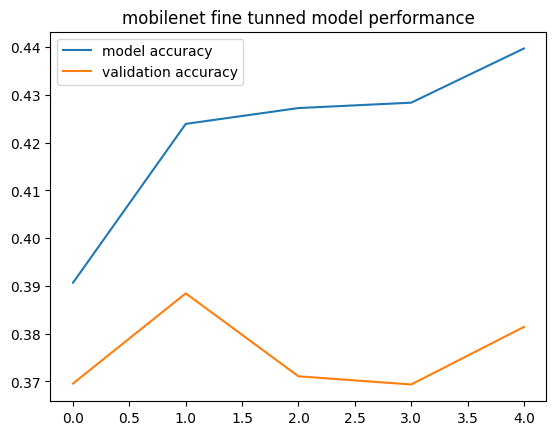

In [12]:
plt.plot(history_mobilenet.history["accuracy"],label = "model accuracy")
plt.plot(history_mobilenet.history["val_accuracy"],label = "validation accuracy")
plt.legend()
plt.title("mobilenet fine tunned model performance")
plt.show()

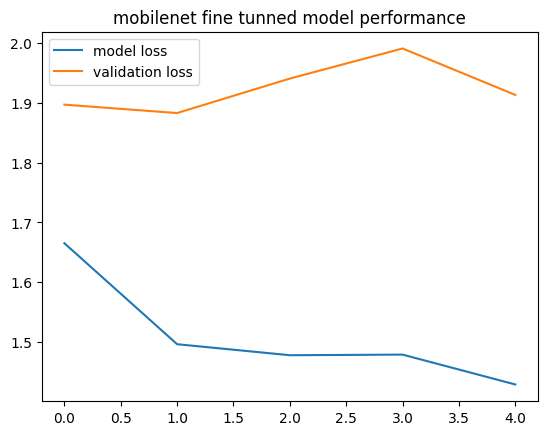

In [13]:
plt.plot(history_mobilenet.history["loss"],label = "model loss")
plt.plot(history_mobilenet.history["val_loss"],label = "validation loss")
plt.legend()
plt.title("mobilenet fine tunned model performance")
plt.show()

# Fine tunned mobilenet

In [14]:
# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the last 50 (example)
fine_tune_at = -50  # (or use base_model.layers count - 50)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (start from previous training epoch)
fine_tune_epochs = 10
# total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    traindata,
    validation_data=validationdata,
    epochs=15,
    # initial_epoch=initial_epochs,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/15


E0000 00:00:1759915779.397268      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759915779.580122      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759915779.843234      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759915780.047249      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1102/1245 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.3197 - loss: 2.0730

E0000 00:00:1759915896.675496      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759915896.857741      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759915897.113743      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759915897.317995      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 172s 118ms/step - accuracy: 0.3250 - loss: 2.0457 - val_accuracy: 0.3939 - val_loss: 1.8834 - learning_rate: 1.0000e-05
Epoch 2/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 136s 109ms/step - accuracy: 0.4211 - loss: 1.5673 - val_accuracy: 0.4074 - val_loss: 1.9264 - learning_rate: 1.0000e-05
Epoch 3/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 140s 113ms/step - accuracy: 0.4568 - loss: 1.4234 - val_accuracy: 0.4277 - val_loss: 1.8806 - learning_rate: 1.0000e-05
Epoch 4/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 137s 110ms/step - accuracy: 0.4867 - loss: 1.3303 - val_accuracy: 0.4381 - val_loss: 1.8433 - learning_rate: 1.0000e-05
Epoch 5/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 137s 110ms/step - accuracy: 0.5043 - loss: 1.2654 - val_accuracy: 0.4496 - val_loss: 1.8212 - learning_rate: 1.0000e-05
Epoch 6/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 134s 108ms/step - accuracy: 0.5215 - loss: 1.2192 - val_accuracy: 0.4571 - val_loss: 1.8130 - learning_rate: 1.0000e-05
Epoch 7/15
1245/1245 ━━━━━━━━━━━━━━━━━━

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt 


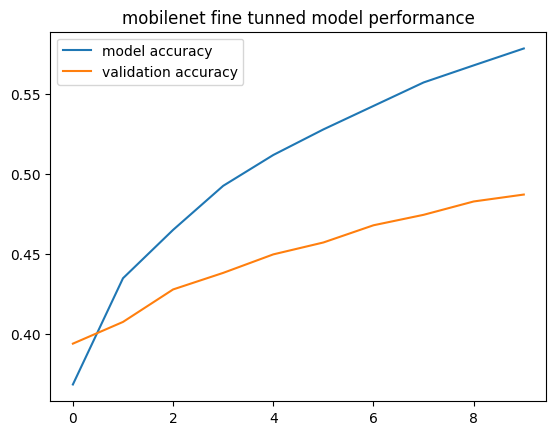

In [16]:
plt.plot(history_fine.history["accuracy"],label = "model accuracy")
plt.plot(history_fine.history["val_accuracy"],label = "validation accuracy")
plt.legend()
plt.title("mobilenet fine tunned model performance")
plt.show()

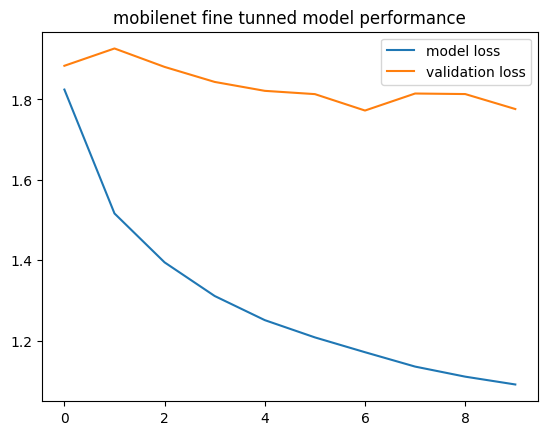

In [17]:
plt.plot(history_fine.history["loss"],label = "model loss")
plt.plot(history_fine.history["val_loss"],label = "validation loss")
plt.legend()
plt.title("mobilenet fine tunned model performance")
plt.show()

In [18]:
# this shows that model starting overfitting

In [19]:
# in further work i will train models by  the upsampling the images with 255,255
# Actually i first train this raw image(96,96) with efficientnet but it only goes to .24% accuracy 
# we can also train by using self made cnn
# one more approch to increase accuracy with adding one more dense layer but at the end it must overfit our model 
# thanks